# M77 Coursework: 3D "Pac-Man"
The following coursework is designed to test multiple components of the module sylabus; including 3D geometry, object detection, feature extraction and image manipulation.

Your task is to complete the below skeleton code to play a Pac-Man-esque game in 3D. You are allowed to utilise method discussed in the course, including feature extractors and deep learning approaches.

The aim of the coursework is to step through a 3D pointcloud of the old PhD lab at Swansea University. Several large spheres have been placed within the space, it is your job to move through the pointcloud in an automated fashion, detecting the location of the sphere and moving to the predicted 3D location. If you land close enough to a sphere it will be captured and removed from the pointcloud. 

You will need to decide what kinds of feature you want to use, extract these features and train a classifier to detect the spheres within an image. You can then use the functionality provided in the PacMan_functionality.py module to obtain the XYZ coordinates of the pixel you predict to be a sphere.


## Imports
Hre we will do our usual imports. I would recommend numpy, scipy, skimage, matplotlib and sklearn. If you wish to utilise the pointcloud processing toolkit you can do that as described in the handout. We will want to import our PacMan_functionality module as well.

In [1]:
import os
from PIL import Image   # https://www.pluralsight.com/guides/Importing-image-data-into-numpy-arrays
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# TODO Sort out imports when CNN architecture is finished.
# TODO replace with import keras then replace from imports

from datetime import datetime

In [2]:
import PacMan_functionality as PacMan

## Game setup.
This cell will initialise the game world and add all of our spheres to the world. Do not edit the code here.

In [3]:
# Call startup_scene() to load the initial game scene
global_cloud, spheres_collected = PacMan.startup_scene()

In [4]:
# View our pointcloud if we want
#v = pptk.viewer(global_cloud['Positions'], global_cloud['Colors']/255) # Fast, requires pptk
#PacMan.show_point_cloud(global_cloud) # Slow, requires matplotlib

## Load the training data: Positives and Negatives
In the handout zip file there is a directory which contains numerous patches extracted from sample images. These patches are labelled as either containing a sphere or not. You may wish to use these to train a classifier for sphere detection.

In [13]:
# Get the training samples for both positive and negative patches

# Define dirs
pos_img_dir = 'TrainingImages/positives/'
neg_img_dir = 'TrainingImages/negatives/'

# go through negatives
neg_images = []
neg_labels = np.zeros( len( os.listdir(neg_img_dir) ) )

for filename in os.listdir(neg_img_dir):
    neg_images.append(np.array(Image.open(neg_img_dir + filename))/255 )  # Normal

print(f'Negative images shape: {np.shape(neg_images)}')

# go through positives
pos_images = []
pos_labels = np.ones( len( os.listdir(pos_img_dir) ) )

for filename in os.listdir(pos_img_dir):
    pos_images.append(np.array(Image.open(pos_img_dir + filename))/255 ) 

print(f'Negative images shape: {np.shape(pos_images)}\n')

# Concatenate the patches into a 4D numpy array (S*H*W*C), and create a label vector (S)

X = np.concatenate((neg_images, pos_images))
y = np.concatenate((neg_labels, pos_labels))

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, stratify=y, random_state=300,shuffle=True)

#Prove test and train data is split correctly
print(f'Training images shape: {X_train.shape}')
print(f'Training labels shape: {y_train.shape}')
print(f'Testing images shape: {X_test.shape}')
print(f'Testing labels shape: {y_test.shape}')

Negative images shape: (2600, 51, 51, 3)
Negative images shape: (308, 51, 51, 3)

Training images shape: (2326, 51, 51, 3)
Training labels shape: (2326,)
Testing images shape: (582, 51, 51, 3)
Testing labels shape: (582,)


## Train a classifier on the samples, this may require feature extraction on the patches
Depending on your desired apporach you may want to extract features on the training patches you have been given. These can then be used to train our desired classifier to detect the patches based not on the raw data, but on a representative feature descriptor. Several are talked about both in the lectures and labs. 

In [6]:
# Extract the features - maybe, might not be needed with representation learning approaches

In [7]:
# Train a classification model to perform binary classification of the patch into whether it contains a sphere.

# Architecture similar to Image Generator but without the augmentations
# Binary Classification CNN Architecture from 
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
# TODO Try their imageGenerator and ensure it will recognise half spheres and that stuff
from tensorflow.keras import datasets, layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), input_shape=(51, 51, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (3, 3), input_shape=(51, 51, 3)))   # Without this layer even the first sphere wouldnt be classified
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3), input_shape=(51, 51, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))  # Prevent overfitting
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

model.save('Final_CNN.h5')    # Save model so it can be reloaded without retraining

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 49, 49, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 49, 49, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 22, 22, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          1

In [8]:
# Just Load model for now
from tensorflow import keras

model = keras.models.load_model('Final_CNN.h5')

## Define my own functions that will be used
sliding_windows,
detect_spheres,
move_to_sphere are defined

In [9]:
# Define function sliding window
# This function goes through windows in an image and returns the x,y coordinates of the start
# of the windows containing spheres, and distance to sphere as a np array
def sliding_window_classifier( step_size, image, depth ):
    #image is (160, 240, 3)
    #window is (51, 51, 3)
    image_hight = image.shape[0] # 160
    image_width = image.shape[1] # 240
    window_size = 51
    result = []

    for y in range(0, image_hight-window_size, step_size): 
        for x in range (0, image_width-window_size, step_size):

            window = image[y:y+window_size, x:x+window_size, :]

            #Normaly you predict on an array of value, but here since we want the (x,y) coordinates this is easier
            window = np.expand_dims(window, axis=0) # Adds first dimension to data (1,51,51,3) -> (1,51,51,3)
            prediction = model.predict( np.array( window ) )
            prediction = prediction[0][0] #  Unpack prediction [[1.]] -> 1

            # Only want patches we are 99.9% sure contain spheres
            if (prediction > 0.999):                
                print(f'Depth: {depth[y+25, x+25]}, Prediction {prediction}')
                plt.figure(figsize=(1,1))
                plt.title('Image')
                plt.imshow( window[0,:,:,:] )   
        
                # Add 'crosshair' to show middle pixel
                ax=plt.gca() 
                ax.spines['left'].set_position('center')
                ax.spines['bottom'].set_position('center')
                ax.xaxis.set_ticks_position('bottom')
                ax.yaxis.set_ticks_position('left')
                plt.show()

                # Spheres are always in the centre of the window.
                # Middle depth is the depth of the pixel in the centre of the sphere and window.
                middle_depth = depth[y+25, x+25]

                # Need these to be returned so we can move to the closest sphere.
                # x, y are now the coordinates of the centre of the sphere.
                result.append( (x+25, y+25, middle_depth) )

    # Results are np array with columns: x, y, depth
    # If length is 0 then no spheres were found
    return np.asarray(result)   

# Not necessary but nicely prints out the current viewpoints
def visualise_maps(image, mapx, mapy, mapz, depth):
    # Inputs can be full 160x240 or 51x51 in size
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,3))

    ax[0].set_title('image')
    im0 = ax[0].imshow(image)
    #fig.colorbar(im, ax=ax[0])

    ax[1].set_title('mapx')
    im1 = ax[1].imshow(mapx, cmap='bwr')
    fig.colorbar(im1, ax=ax[1])

    ax[2].set_title('mapy')
    im2 = ax[2].imshow(mapy, cmap='bwr')
    fig.colorbar(im2, ax=ax[2])

    ax[3].set_title('mapz')
    im3 = ax[3].imshow(mapz, cmap='bwr')
    fig.colorbar(im3, ax=ax[3])

    ax[4].set_title('depth')
    im4 = ax[4].imshow(depth, cmap='bwr')
    fig.colorbar(im4, ax=ax[4])
    plt.show()
    print()

## Initialise our starting point in the game and get our first view into the scene
We should start the game at a position of XYZ = [0, 0, 0] and a camera angle of [0, 0, 0]. These variables can be updated once we find a sphere, or rotated when we don't find a sphere. We can then get our first image projected to the camera plane to start our game. 

In [10]:
# Initialise position and angle variable 
position = np.zeros([3])
angle = np.zeros([3])

In [11]:
# Get the image, XYZ maps and depth map of the current viewpoint into the scene


## Perform our loop, in which we will perform pixel-wise prediction on binary class label and then perform the correct action based on detection of spheres.
This will be the main bulk of your implementation, utilising the feature descriptors and trained models from the above cells. In each loop of the program we will want to:
-  Get current view into the scene
-  Extract patches from the scene
-  Extract features on the patches
-  Use the pretrained model to obtain class prediction probabilities
-  Identify if a sphere has been found in the scene
  -  If so, find the mapped XYZ location, move there and update the scene
  -  If not, rotate the camera in a bid to find the sphere


Start time:
16:12:45
Getting maps.... may take a while


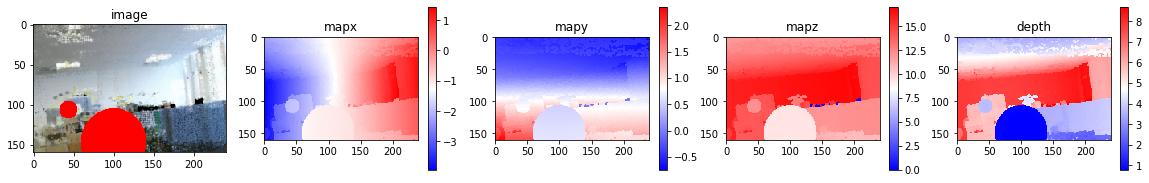


Depth: 3.6821495927556844, Prediction 0.9998735189437866


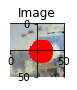

Depth: 3.6789669759053276, Prediction 0.9999445676803589


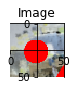

Depth: 3.6839207717374713, Prediction 0.9999128580093384


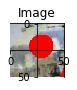

Depth: 3.6808268486510425, Prediction 0.9999723434448242


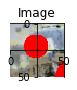

Depth: 0.8283602065340495, Prediction 0.9996633529663086


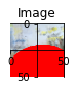

Depth: 0.8271734533218531, Prediction 0.9998346567153931


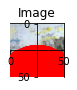

Depth: 0.8282899020220399, Prediction 0.9998219609260559


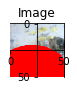

Depth: 0.832791014621903, Prediction 0.9995385408401489


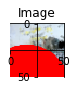

Depth: 0.8308182855925096, Prediction 0.9997559189796448


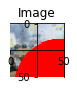

Depth: 0.8179148468815013, Prediction 0.9999741315841675


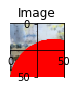

Depth: 0.812133147601149, Prediction 0.9999933242797852


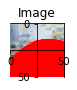

Depth: 0.8079452251397894, Prediction 0.9999973773956299


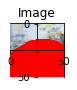

Depth: 0.807121499094922, Prediction 0.9999982118606567


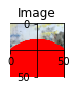

Depth: 0.8080436915397092, Prediction 0.9999980926513672


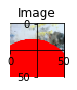

Depth: 0.811881179756938, Prediction 0.9999967813491821


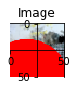

Depth: 0.8192385855423866, Prediction 0.9999887943267822


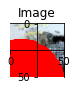

Depth: 0.8318843479451756, Prediction 0.9996798038482666


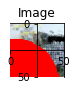

Depth: 0.8260874057249005, Prediction 0.999956488609314


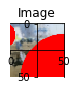

Depth: 0.8137987798009875, Prediction 0.9999959468841553


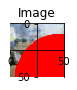

Depth: 0.8036713144315488, Prediction 0.9999991655349731


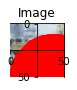

Depth: 0.7982960061349219, Prediction 0.9999996423721313


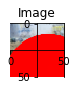

Depth: 0.7958309342929457, Prediction 0.9999997615814209


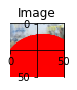

Depth: 0.7949574270974501, Prediction 0.9999997615814209


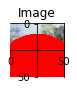

Depth: 0.7957030197186649, Prediction 0.9999997615814209


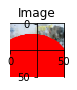

Depth: 0.7990946921600619, Prediction 0.9999996423721313


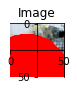

Depth: 0.8042840518207396, Prediction 0.9999994039535522


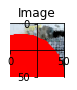

Depth: 0.8129204704225789, Prediction 0.9999970197677612


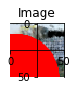

Depth: 0.8256409291278793, Prediction 0.9997701048851013


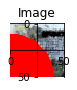

Depth: 0.8299111545426718, Prediction 0.9999064207077026


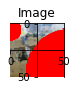

Depth: 0.8116869531410592, Prediction 0.9999973773956299


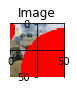

Depth: 0.8015397858712484, Prediction 0.9999995231628418


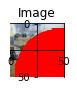

Depth: 0.7938787129869547, Prediction 0.9999997615814209


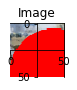

Depth: 0.7892689427984657, Prediction 0.9999997615814209


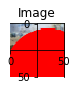

Depth: 0.7869184784164874, Prediction 0.9999996423721313


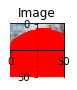

Depth: 0.7860593150437537, Prediction 0.9999996423721313


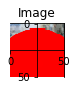

Depth: 0.7866921921342223, Prediction 0.9999996423721313


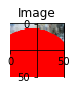

Depth: 0.7895545005720949, Prediction 0.9999996423721313


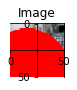

Depth: 0.7941922504633464, Prediction 0.9999997615814209


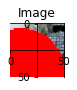

Depth: 0.801901337463455, Prediction 0.9999995231628418


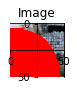

Depth: 0.8135597168532612, Prediction 0.9999966621398926


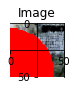

Depth: 0.818691815384492, Prediction 0.9999921321868896


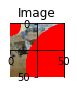

Depth: 0.8039339995316366, Prediction 0.9999992847442627


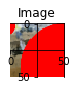

Depth: 0.7941615363623603, Prediction 0.9999996423721313


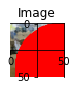

Depth: 0.787110492557173, Prediction 0.9999996423721313


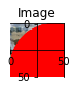

Depth: 0.7829471505521074, Prediction 0.9999995231628418


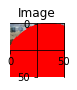

Depth: 0.7807874924425683, Prediction 0.9999994039535522


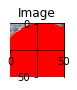

Depth: 0.7799927337466246, Prediction 0.9999992847442627


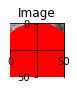

Depth: 0.7804977287347494, Prediction 0.9999992847442627


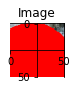

Depth: 0.7828509696853578, Prediction 0.9999994039535522


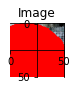

Depth: 0.7876451491207965, Prediction 0.9999996423721313


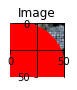

Depth: 0.7936667113140861, Prediction 0.9999997615814209


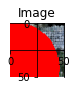

Depth: 0.8041650067003029, Prediction 0.9999995231628418


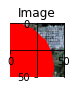

Depth: 0.8174653584315545, Prediction 0.9999868869781494


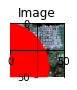

I am at position [-0.98716134  0.4513351   8.62567329]
I have found 3 out of 11 spheres!

I am now at position [-1.03571814  0.58285936  9.3929622 ]
I have found 4 out of 11 spheres!

Getting maps.... may take a while


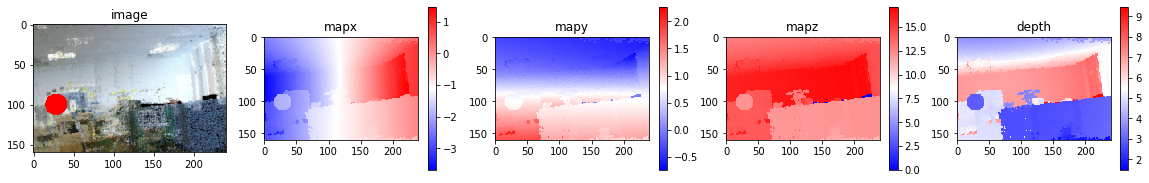


Depth: 2.926918883354637, Prediction 0.9999644756317139


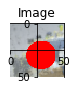

Depth: 2.9247959187278845, Prediction 0.9999755620956421


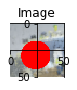

Depth: 2.9349204527531545, Prediction 0.9990505576133728


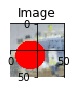

Depth: 2.920393401003912, Prediction 0.999998927116394


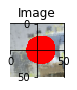

Depth: 2.9188112088482727, Prediction 0.9999991655349731


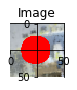

Depth: 2.928359528006017, Prediction 0.9999674558639526


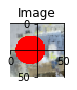

Depth: 2.9248350459735284, Prediction 0.999995231628418


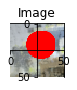

Depth: 2.92310472771768, Prediction 0.9999966621398926


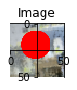

Depth: 2.9339628591349762, Prediction 0.9995868802070618


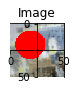

I am at position [-1.03571814  0.58285936  9.3929622 ]
I have found 4 out of 11 spheres!

I am now at position [-1.88541568  0.77117301 12.17900078]
I have found 5 out of 11 spheres!

Getting maps.... may take a while


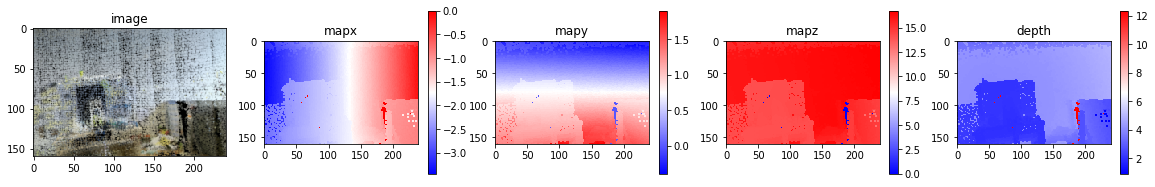


### No spheres found, rotating
Getting maps.... may take a while


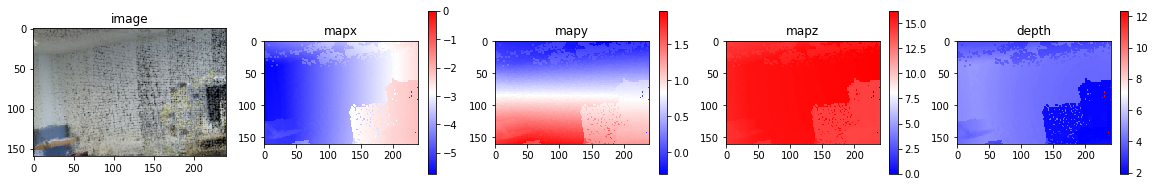


### No spheres found, rotating
Getting maps.... may take a while


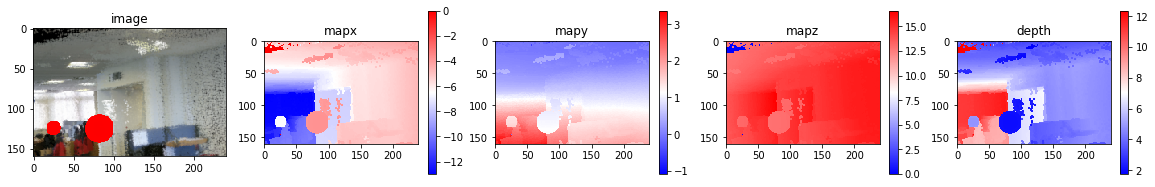


Depth: 2.0528007080592796, Prediction 0.9997525811195374


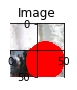

Depth: 2.0430637129774705, Prediction 0.9999712705612183


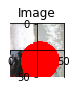

Depth: 2.042311266607636, Prediction 0.9999698400497437


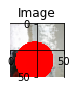

Depth: 2.052688009872877, Prediction 0.9991707801818848


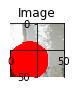

Depth: 2.0569302010768964, Prediction 0.999754011631012


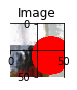

Depth: 2.036220476867227, Prediction 0.999996542930603


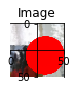

Depth: 2.02826185819671, Prediction 0.9999995231628418


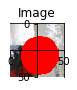

Depth: 2.0280852013500574, Prediction 0.9999995231628418


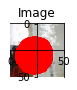

Depth: 2.036584892942096, Prediction 0.9999959468841553


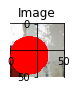

Depth: 2.0521985244310783, Prediction 0.9999752044677734


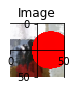

Depth: 2.031906499667199, Prediction 0.9999995231628418


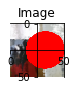

Depth: 2.0246313844646897, Prediction 0.9999998807907104


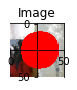

Depth: 2.024783862270779, Prediction 0.9999998807907104


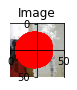

Depth: 2.032682552329214, Prediction 0.999998927116394


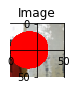

Depth: 2.0548689613780113, Prediction 0.9997262358665466


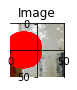

Depth: 2.054631292626263, Prediction 0.9999841451644897


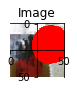

Depth: 2.033869535501716, Prediction 0.9999995231628418


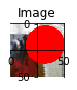

Depth: 2.027058085979466, Prediction 0.9999997615814209


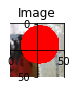

Depth: 2.0273535775068936, Prediction 0.9999997615814209


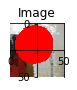

Depth: 2.0353736057585423, Prediction 0.9999971389770508


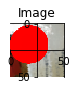

I am at position [-1.88541568  0.77117301 12.17900078]
I have found 5 out of 11 spheres!

I am now at position [-3.73314763  1.07209084 12.95001787]
I have found 6 out of 11 spheres!

Getting maps.... may take a while


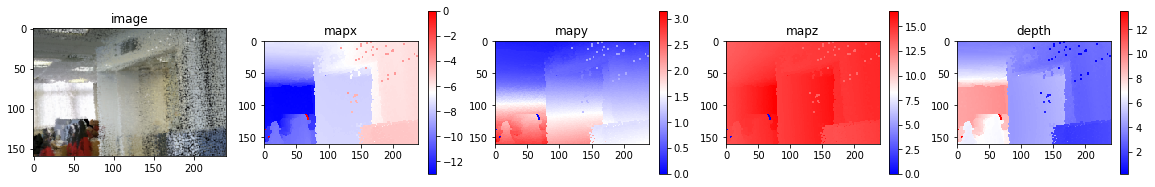


### No spheres found, rotating
Getting maps.... may take a while


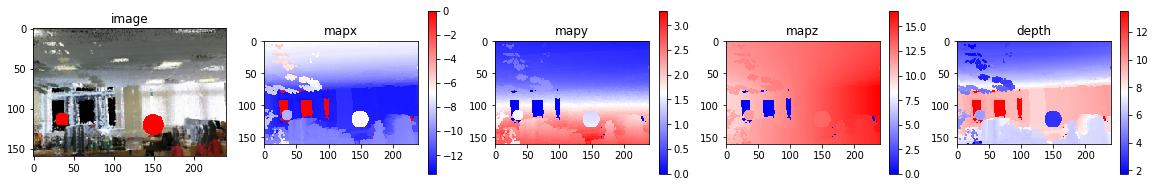


Depth: 2.8739326254516446, Prediction 0.9998360872268677


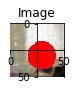

Depth: 2.870263924621543, Prediction 0.9999446868896484


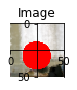

Depth: 2.891191568355865, Prediction 0.9994474053382874


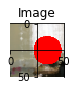

Depth: 2.865763642732906, Prediction 0.9999967813491821


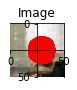

Depth: 2.8626222167564412, Prediction 0.9999991655349731


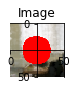

Depth: 2.870788039086878, Prediction 0.9999849796295166


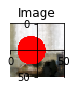

Depth: 2.8969121665773656, Prediction 0.9991512298583984


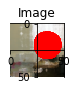

Depth: 2.869415425556531, Prediction 0.9999939203262329


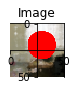

Depth: 2.866469057055554, Prediction 0.9999986886978149


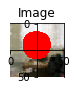

Depth: 2.874488150186492, Prediction 0.9999691247940063


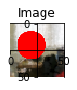

Depth: 2.8978407730458513, Prediction 0.9995348453521729


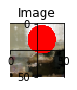

Depth: 2.8917012798749773, Prediction 0.9998427629470825


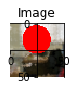

I am at position [-3.73314763  1.07209084 12.95001787]
I have found 6 out of 11 spheres!

I am now at position [-6.55665426  1.45563589 13.22444352]
I have found 7 out of 11 spheres!

Getting maps.... may take a while


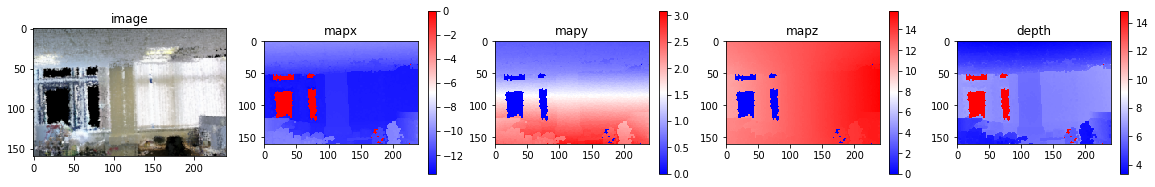


### No spheres found, rotating
Getting maps.... may take a while


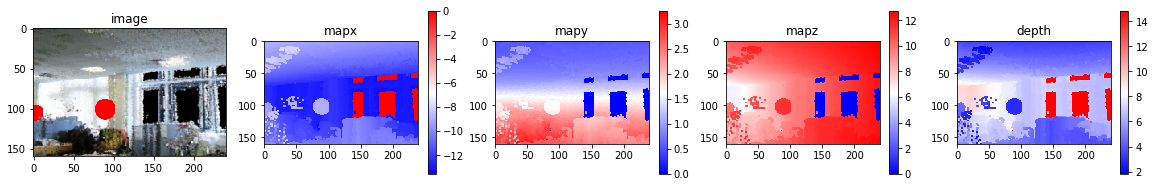


Depth: 2.911341506111108, Prediction 0.999567449092865


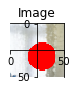

Depth: 2.9074960713887212, Prediction 0.9998927116394043


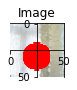

Depth: 2.9000349186292476, Prediction 0.9999933242797852


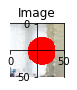

Depth: 2.89654053803425, Prediction 0.9999985694885254


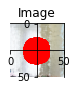

Depth: 2.9046097931437056, Prediction 0.999976634979248


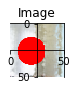

Depth: 2.901995332426313, Prediction 0.9999891519546509


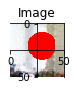

Depth: 2.898783809906435, Prediction 0.9999983310699463


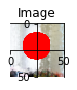

Depth: 2.9070683532606996, Prediction 0.9999504089355469


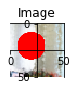

Depth: 2.9213403824595887, Prediction 0.9991981387138367


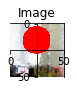

I am at position [-6.55665426  1.45563589 13.22444352]
I have found 7 out of 11 spheres!

I am now at position [-8.89900816  1.65984053 11.53280947]
I have found 8 out of 11 spheres!

Getting maps.... may take a while


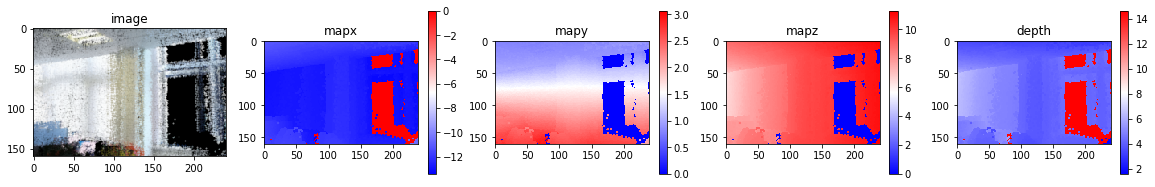


### No spheres found, rotating
Getting maps.... may take a while


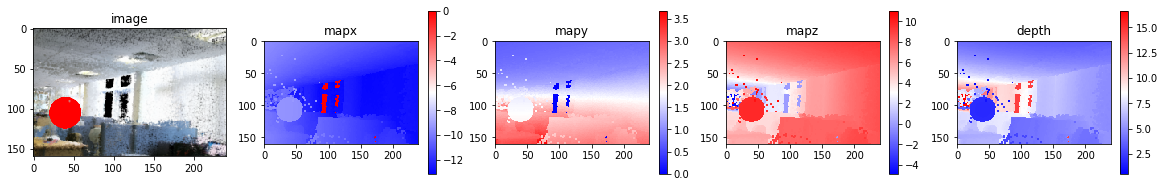


Depth: 1.8587669542802954, Prediction 0.9999065399169922


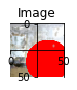

Depth: 1.845448333290471, Prediction 0.9999897480010986


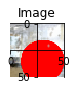

Depth: 1.8425303382168325, Prediction 0.9999939203262329


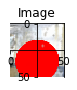

Depth: 1.8455716272486422, Prediction 0.9999865293502808


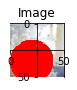

Depth: 1.8570555467879113, Prediction 0.9992744326591492


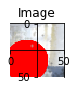

Depth: 1.8663937373833677, Prediction 0.9997333884239197


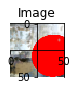

Depth: 1.8436448556647254, Prediction 0.9999972581863403


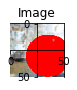

Depth: 1.8328514815572199, Prediction 0.9999996423721313


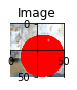

Depth: 1.8304484266291188, Prediction 0.9999997615814209


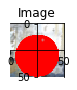

Depth: 1.8325926849389773, Prediction 0.9999996423721313


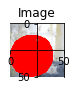

Depth: 1.8428611007321727, Prediction 0.9999945163726807


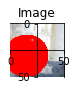

Depth: 1.860468178050012, Prediction 0.999957799911499


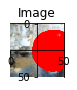

Depth: 1.8393862418635758, Prediction 0.9999994039535522


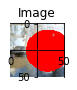

Depth: 1.829552888459325, Prediction 0.9999998807907104


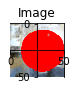

Depth: 1.8275941114926408, Prediction 0.9999998807907104


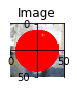

Depth: 1.8295416705936614, Prediction 0.9999998807907104


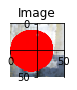

Depth: 1.8396277894781106, Prediction 0.9999986886978149


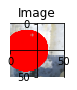

Depth: 1.8620806770888794, Prediction 0.999180257320404


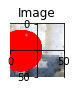

Depth: 1.8620093967336475, Prediction 0.999966025352478


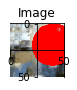

Depth: 1.841090377814012, Prediction 0.9999992847442627


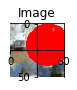

Depth: 1.830989215649936, Prediction 0.9999997615814209


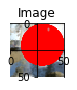

Depth: 1.8290230850563853, Prediction 0.9999997615814209


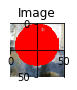

Depth: 1.8310921687750432, Prediction 0.9999996423721313


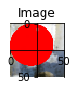

Depth: 1.841601308278022, Prediction 0.9999971389770508


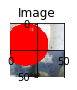

Depth: 1.8760994846878503, Prediction 0.9997567534446716


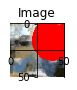

Depth: 1.8515476715486754, Prediction 0.9999959468841553


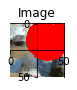

Depth: 1.8403427586257162, Prediction 0.9999990463256836


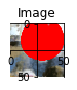

Depth: 1.8384859248397147, Prediction 0.9999991655349731


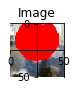

Depth: 1.8409954988186805, Prediction 0.9999979734420776


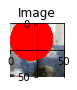

Depth: 1.8539129095617164, Prediction 0.9999463558197021


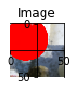

Depth: 1.8765777447530343, Prediction 0.9995121955871582


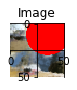

Depth: 1.8627281428693117, Prediction 0.9999303817749023


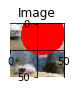

Depth: 1.8597750058536175, Prediction 0.9999440908432007


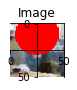

Depth: 1.863874155384175, Prediction 0.9997145533561707


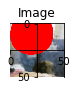

I am at position [-8.89900816  1.65984053 11.53280947]
I have found 8 out of 11 spheres!

I am now at position [-9.37181819  1.80962078  9.7737993 ]
I have found 9 out of 11 spheres!

Getting maps.... may take a while


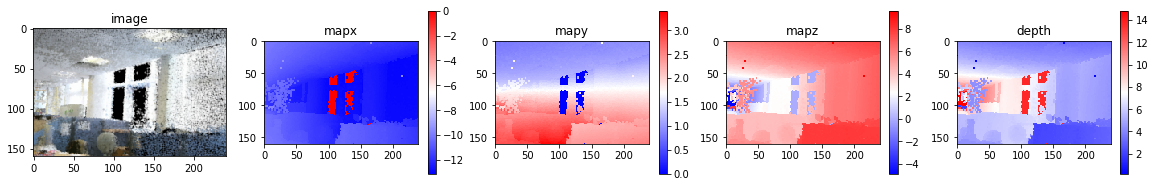


### No spheres found, rotating
Getting maps.... may take a while


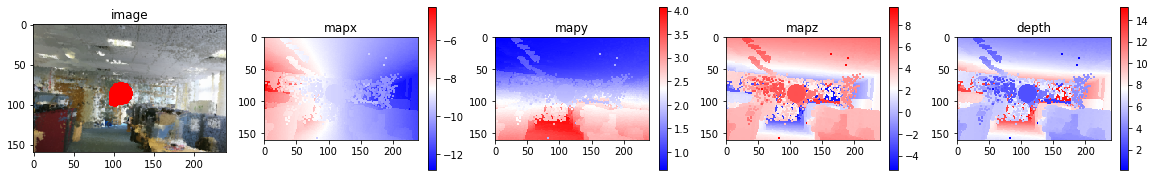


Depth: 2.523050017390526, Prediction 0.9999637603759766


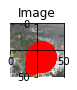

Depth: 2.520441708418889, Prediction 0.9999798536300659


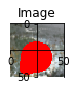

Depth: 2.529281987499349, Prediction 0.9997656941413879


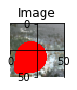

Depth: 2.5310636409654985, Prediction 0.9999685287475586


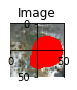

Depth: 2.5122398280906197, Prediction 0.9999991655349731


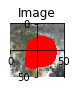

Depth: 2.5100322420470382, Prediction 0.9999994039535522


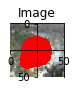

Depth: 2.5170592580454025, Prediction 0.999991774559021


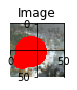

Depth: 2.532618803868541, Prediction 0.9999929666519165


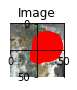

Depth: 2.5130446924131813, Prediction 0.9999996423721313


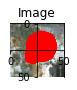

Depth: 2.510727710506857, Prediction 0.9999996423721313


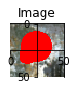

Depth: 2.518209425650514, Prediction 0.9999843835830688


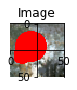

Depth: 2.551286190200092, Prediction 0.9999490976333618


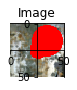

Depth: 2.528151159483369, Prediction 0.9999954700469971


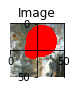

Depth: 2.525237747701021, Prediction 0.9999841451644897


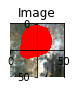

I am at position [-9.37181819  1.80962078  9.7737993 ]
I have found 9 out of 11 spheres!

I am now at position [-9.27846328  1.86393573  7.26609186]
I have found 10 out of 11 spheres!

Getting maps.... may take a while


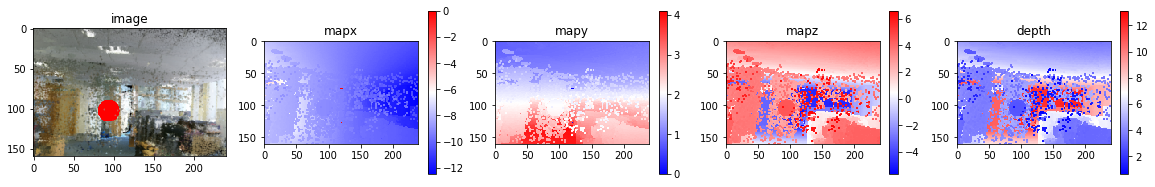


Depth: 2.7497731923412223, Prediction 0.9995623230934143


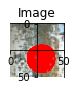

Depth: 2.7474291718432613, Prediction 0.9997380375862122


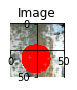

Depth: 2.7518959618617824, Prediction 0.9995070695877075


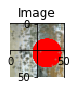

Depth: 2.7314972283372527, Prediction 0.9999945163726807


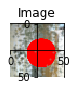

Depth: 2.7293481738822045, Prediction 0.9999980926513672


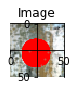

Depth: 2.739084650801551, Prediction 0.9999266862869263


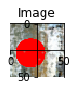

Depth: 2.7507220017875764, Prediction 0.9997794032096863


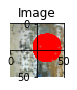

Depth: 2.730074877838634, Prediction 0.9999988079071045


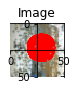

Depth: 2.728171651007545, Prediction 0.9999996423721313


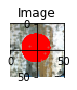

Depth: 2.737878853595555, Prediction 0.999981164932251


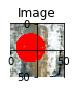

Depth: 2.7419820231039997, Prediction 0.9999743700027466


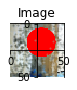

Depth: 2.739221333028126, Prediction 0.9999916553497314


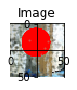

Depth: 2.7513922325537497, Prediction 0.9992201328277588


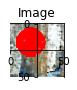

I am at position [-9.27846328  1.86393573  7.26609186]
I have found 10 out of 11 spheres!

I am now at position [-9.04149477  2.07629341  4.55654011]
I have found 11 out of 11 spheres!



In [14]:
print('Start time:')
print(datetime.now().strftime('%H:%M:%S') ) # Used to time the execution of the program.

window_step_size = 5   # How big the steps are between windows
rotation_angle = np.pi*1/6 # will rotate π/6 or 30°

while not np.all(spheres_collected): # While there are spheres to find
    # Get current image from viewpoint
    print('Getting maps.... may take a while')
    image, mapx, mapy, mapz, depth = PacMan.project_pointcloud_image(global_cloud, angle, position)
    visualise_maps(image, mapx, mapy, mapz, depth)

    # Extract patches from the scene
    # Extract features from the patches    
    # Predict the probability of a pixel being a sphere, based on the patch
    # Use probabilities to find sphere coordinates in 3D
    sphere_windows = sliding_window_classifier(window_step_size, image, depth)

    # Update camera appropriately
    if ( len(sphere_windows) == 0):
        #rotate
        print('### No spheres found, rotating')
        angle = angle - np.asarray([0, rotation_angle, 0])   # numpy - is an elementwise operation 

    else:   # Spheres have been detected
        # Find the location of the window with lowest depth, which will show the closest sphere
        # sphere_windows has columns (x, y, depth)
        min_index = np.argmin( sphere_windows[:,2] )# Get the index of the closest sphere 
        x = int( sphere_windows[min_index, 0] )     # Get x location of start of sphere
        y = int( sphere_windows[min_index, 1] )    

        # Get spacial coordinates of new sphere
        newx = mapx[y, x] # I want Y, X not X, Y 
        newy = mapy[y, x] 
        newz = mapz[y, x] 

        # Move position and update scene
        print(f'I am at position {position}')
        print(f'I have found {np.sum(spheres_collected)} out of {len(spheres_collected)} spheres!\n')

        position = np.asarray([newx, newy, newz])
        print(f'I am now at position {position}')
        
        # Update scene
        global_cloud, spheres_collected = PacMan.update_scene(position, spheres_collected);
        print(f'I have found {np.sum(spheres_collected)} out of {len(spheres_collected)} spheres!\n')
